# <font color="red">**3. PCA FS - Fine-tuning Hyperparameters**</font>

**Author:** Osmar Bolivar

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objects as go

In [65]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## **1. Monthly data**

In [2]:
raw = pd.read_csv("./Data/PC_DATASET.csv", index_col=0)
raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5901 entries, 2010-01-01 to 2024-10-31
Data columns (total 87 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ipc_all  178 non-null    float64
 1   lag_1    5901 non-null   float64
 2   lag_2    5901 non-null   float64
 3   lag_3    5901 non-null   float64
 4   lag_6    5901 non-null   float64
 5   lag_9    5901 non-null   float64
 6   lag_12   5901 non-null   float64
 7   freq     5901 non-null   object 
 8   PC_1     5901 non-null   float64
 9   PC_2     5901 non-null   float64
 10  PC_3     5901 non-null   float64
 11  PC_4     5901 non-null   float64
 12  PC_5     5901 non-null   float64
 13  PC_6     5901 non-null   float64
 14  PC_7     5901 non-null   float64
 15  PC_8     5901 non-null   float64
 16  PC_9     5901 non-null   float64
 17  PC_10    5901 non-null   float64
 18  PC_11    5901 non-null   float64
 19  PC_12    5901 non-null   float64
 20  PC_13    5901 non-null   float64
 21  PC_1

In [3]:
df = raw.copy().query('freq == "month"')
df.drop(columns=["freq"], inplace=True)

df_w = raw.copy().query('freq == "week"')
df_w.drop(columns=["freq"], inplace=True)

df_d = raw.copy().query('freq == "day"')
df_d.drop(columns=["freq"], inplace=True)

In [4]:
isna = df.isna().sum()
isna[isna > 0]

Series([], dtype: int64)

In [5]:
df.shape

(178, 86)

## **2. Train and Val sets**

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
train_size = int(len(df) * 0.8)
train, validation = df[:train_size], df[train_size:]
print(f'Obs in train set: {train.shape[0]}; variables in train set: {train.shape[1]}')
print(f'Obs in validation set: {validation.shape[0]}; variables in validation set: {validation.shape[1]}')

Obs in train set: 142; variables in train set: 86
Obs in validation set: 36; variables in validation set: 86


In [ ]:
test_w = df_w.copy()
test_d = df_d.copy()
print(f'Obs in weekly test set: {test_w.shape[0]}; variables in weekly test set: {test_w.shape[1]}')
print(f'Obs in daily test set: {test_d.shape[0]}; variables in daily test set: {test_d.shape[1]}')

Obs in weekly test set: 305; variables in weekly test set: 86
Obs in daily test set: 5418; variables in daily test set: 86


In [14]:
scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)
validation_scaled = pd.DataFrame(scaler.transform(validation), columns=validation.columns, index=validation.index)
test_scaled_w = pd.DataFrame(scaler.transform(test_w), columns=test_w.columns, index=test_w.index)
test_scaled_d = pd.DataFrame(scaler.transform(test_d), columns=test_d.columns, index=test_d.index)

X_train = train_scaled.drop('ipc_all', axis=1)
y_train = train['ipc_all']

X_validation = validation_scaled.drop('ipc_all', axis=1)
y_validation = validation['ipc_all']

X_test_w = test_scaled_w.drop('ipc_all', axis=1)
X_test_d = test_scaled_d.drop('ipc_all', axis=1)

## **3. Algorithms**

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

tscv5 = TimeSeriesSplit(n_splits=5)

### **3.1. Ridge**   

**Without tuning (Validation):**
MSE:  2.209; R2:  0.001; MAE:  1.256

In [24]:
#ridge = Ridge(random_state=0)
ridge = Ridge(alpha=20.0, fit_intercept=True, positive=False, random_state=0) 
# Fit on training set
ridge.fit(X_train, y_train)
# Make predictions on validation set using best model from GridSearchCV
ridge_train_pred = ridge.predict(X_train)
ridge_val_pred = ridge.predict(X_validation)
# Calculate Forecast metrics on train set
mse_train_ridge = mean_squared_error(y_train, ridge_train_pred)
r2_train_ridge = r2_score(y_train, ridge_train_pred)
mae_train_ridge = mean_absolute_error(y_train, ridge_train_pred)
print("Train MSE: ", mse_train_ridge)
print("Train R2: ", r2_train_ridge)
print("Train MAE: ", mae_train_ridge)
# Calculate Forecast metrics on validation set
mse_val_ridge = mean_squared_error(y_validation, ridge_val_pred)
r2_val_ridge = r2_score(y_validation, ridge_val_pred)
mae_val_ridge = mean_absolute_error(y_validation, ridge_val_pred)
print("Validation MSE: ", mse_val_ridge)
print("Validation R2: ", r2_val_ridge)
print("Validation MAE: ", mae_val_ridge)

ridge_test_pred_w = ridge.predict(X_test_w)
ridge_test_pred_d = ridge.predict(X_test_d)

Train MSE:  0.08331439457953614
Train R2:  0.9880986113795015
Train MAE:  0.21268915849003725
Validation MSE:  1.2186145011826564
Validation R2:  0.448607879923571
Validation MAE:  0.7393753297557668


In [25]:
# Get the coefficients from the Ridge model
coef = ridge.coef_
feature_importance_ridge = pd.DataFrame({'Feature': X_train.columns, 'Importance': coef})
feature_importance_ridge = feature_importance_ridge.sort_values('Importance', ascending=False).reset_index(drop=True)
feature_importance_ridge.columns = ['feat_ridge', 'imp_ridge']
feature_importance_ridge.head(15)

,feat_ridge,imp_ridge
0,lag_1,0.641836
1,lag_2,0.466563
2,lag_3,0.387335
3,lag_6,0.295811
4,PC_13,0.217584
5,PC_12,0.185423
6,PC_20,0.138465
7,PC_6,0.124164
8,PC_17,0.119212
9,lag_9,0.113126


### **3.2. Lasso**
Without tuning:
Validation MSE:  0.796
Validation R2:  0.640
Validation MAE:  0.690

In [27]:
#lasso = Lasso(random_state=0)
lasso = Lasso(alpha=0.17, fit_intercept=True, max_iter=10000, random_state=0)  
# Fit on training set
lasso.fit(X_train, y_train)
# Make predictions on validation set using best model from GridSearchCV
lasso_train_pred = lasso.predict(X_train)
lasso_val_pred = lasso.predict(X_validation)
# Calculate Forecast metrics on train set
mse_train_lasso = mean_squared_error(y_train, lasso_train_pred)
r2_train_lasso = r2_score(y_train, lasso_train_pred)
mae_train_lasso = mean_absolute_error(y_train, lasso_train_pred)
print("Train MSE: ", mse_train_lasso)
print("Train R2: ", r2_train_lasso)
print("Train MAE: ", mae_train_lasso)
# Calculate Forecast metrics on validation set
mse_val_lasso = mean_squared_error(y_validation, lasso_val_pred)
r2_val_lasso = r2_score(y_validation, lasso_val_pred)
mae_val_lasso = mean_absolute_error(y_validation, lasso_val_pred)
print("Validation MSE: ", mse_val_lasso)
print("Validation R2: ", r2_val_lasso)
print("Validation MAE: ", mae_val_lasso)

lasso_test_pred_w = lasso.predict(X_test_w)
lasso_test_pred_d = lasso.predict(X_test_d)

Train MSE:  0.3974961328026871
Train R2:  0.9432180240220815
Train MAE:  0.46428137421744925
Validation MSE:  0.316992258323061
Validation R2:  0.8565690518248895
Validation MAE:  0.3992437620146129


In [28]:
# Get the coefficients from the Lasso model
coef = lasso.coef_
# Create a dataframe of feature importances
feature_importance_lasso = pd.DataFrame({'Feature': X_train.columns, 'Importance': coef})
# Sort the features by importance
feature_importance_lasso = feature_importance_lasso.sort_values('Importance', ascending=False).reset_index(drop=True)
feature_importance_lasso.columns = ['feat_lasso', 'imp_lasso']
# Print the feature importances
feature_importance_lasso.head(15)

,feat_lasso,imp_lasso
0,lag_1,2.252408
1,PC_13,0.005075
2,PC_59,0.000000
3,PC_57,0.000000
4,PC_56,0.000000
5,PC_55,0.000000
6,PC_54,0.000000
7,PC_53,0.000000
8,PC_52,-0.000000
9,PC_51,0.000000


### **3.4. ADA**
Without tuning:
Validation MSE:  0.324
Validation R2:  0.853
Validation MAE:  0.429

In [29]:
#ada = AdaBoostRegressor(random_state=0)
ada = AdaBoostRegressor(learning_rate=0.99, random_state=0)
# Fit the model on training data
ada.fit(X_train, y_train)
# Make predictions on the validation set
ada_train_pred = ada.predict(X_train)
ada_val_pred = ada.predict(X_validation)
# Calculate Forecast metrics on train set
mse_train_ada = mean_squared_error(y_train, ada_train_pred)
r2_train_ada = r2_score(y_train, ada_train_pred)
mae_train_ada = mean_absolute_error(y_train, ada_train_pred)
print("Train MSE: ", mse_train_ada)
print("Train R2: ", r2_train_ada)
print("Train MAE: ", mae_train_ada)
# Evaluate the model on the validation set
mse_val_ada = mean_squared_error(y_validation, ada_val_pred)
r2_val_ada = r2_score(y_validation, ada_val_pred)
mae_val_ada = mean_absolute_error(y_validation, ada_val_pred)
print("Validation MSE: ", mse_val_ada)
print("Validation R2: ", r2_val_ada)
print("Validation MAE: ", mae_val_ada)

ada_test_pred_w = ada.predict(X_test_w)
ada_test_pred_d = ada.predict(X_test_d)

Train MSE:  0.1374454907949773
Train R2:  0.9803660314842166
Train MAE:  0.30455703836714393
Validation MSE:  0.2829375587968081
Validation R2:  0.8719779386813342
Validation MAE:  0.4079052357259496


In [30]:
# Create a DataFrame with the feature importance values
feature_importance_ada = pd.DataFrame({'Feature': X_train.columns, 'Importance': ada.feature_importances_})
# Sort the DataFrame by importance values in descending order
feature_importance_ada = feature_importance_ada.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_ada.columns = ['feat', 'imp_ada']
# Print the feature importance DataFrame
feature_importance_ada.head(15)

,feat,imp_ada
0,lag_1,0.774942
1,PC_2,0.093845
2,lag_2,0.025062
3,PC_3,0.021132
4,PC_11,0.006910
5,PC_9,0.004398
6,PC_6,0.004146
7,lag_12,0.004020
8,PC_62,0.003982
9,PC_43,0.003851


### **3.5. GBR**
Without tuning:
Validation MSE:  0.277
Validation R2:  0.874
Validation MAE:  0.414

In [31]:
#gbr = GradientBoostingRegressor(random_state=0)
gbr = GradientBoostingRegressor(learning_rate=0.2, random_state=0)
# Fit the model on the training set
gbr.fit(X_train, y_train)
# Make predictions on validation set using best model from GridSearchCV
gbr_train_pred = gbr.predict(X_train)
gbr_val_pred = gbr.predict(X_validation)
# Calculate Forecast metrics on train set
mse_train_gbr = mean_squared_error(y_train, gbr_train_pred)
r2_train_gbr = r2_score(y_train, gbr_train_pred)
mae_train_gbr = mean_absolute_error(y_train, gbr_train_pred)
print("Train MSE: ", mse_train_gbr)
print("Train R2: ", r2_train_gbr)
print("Train MAE: ", mae_train_gbr)
# Calculate Forecast metrics on validation set
mse_val_gbr = mean_squared_error(y_validation, gbr_val_pred)
r2_val_gbr = r2_score(y_validation, gbr_val_pred)
mae_val_gbr = mean_absolute_error(y_validation, gbr_val_pred)
print("Validation MSE: ", mse_val_gbr)
print("Validation R2: ", r2_val_gbr)
print("Validation MAE: ", mae_val_gbr)

gbr_test_pred_w = gbr.predict(X_test_w)
gbr_test_pred_d = gbr.predict(X_test_d)

Train MSE:  2.3706636807468787e-05
Train R2:  0.9999966135276028
Train MAE:  0.0039753753891760705
Validation MSE:  0.2638828490091416
Validation R2:  0.8805997110441823
Validation MAE:  0.4014125402614676


In [32]:
# Create a DataFrame with the feature importance values
feature_importance_gbr = pd.DataFrame({'Feature': X_train.columns, 'Importance': gbr.feature_importances_})
# Sort the DataFrame by importance values in descending order
feature_importance_gbr = feature_importance_gbr.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_gbr.columns = ['feat_gbr', 'imp_gbr']
# Print the feature importance DataFrame
feature_importance_gbr.head(15)

,feat_gbr,imp_gbr
0,lag_1,0.881219
1,PC_3,0.031463
2,PC_2,0.026456
3,lag_12,0.008302
4,PC_66,0.006572
5,PC_41,0.003842
6,PC_44,0.003293
7,PC_11,0.003210
8,PC_1,0.002733
9,PC_22,0.002731


### **3.4. RF**
Without tuning:
Validation MSE:  0.324
Validation R2:  0.853
Validation MAE:  0.434

In [33]:
#rf = RandomForestRegressor(random_state=0)
rf = RandomForestRegressor(criterion="absolute_error", max_depth=6, n_estimators=105, random_state=0)

# Fit the model to the training data and make predictions on the validation set
rf.fit(X_train, y_train)
# Make predictions on validation set using best model from GridSearchCV
rf_train_pred = rf.predict(X_train)
rf_val_pred = rf.predict(X_validation)
# Calculate Forecast metrics on train set
mse_train_rf = mean_squared_error(y_train, rf_train_pred)
r2_train_rf = r2_score(y_train, rf_train_pred)
mae_train_rf = mean_absolute_error(y_train, rf_train_pred)
print("Train MSE: ", mse_train_rf)
print("Train R2: ", r2_train_rf)
print("Train MAE: ", mae_train_rf)
# Calculate Forecast metrics on validation set
mse_val_rf = mean_squared_error(y_validation, rf_val_pred)
r2_val_rf = r2_score(y_validation, rf_val_pred)
mae_val_rf = mean_absolute_error(y_validation, rf_val_pred)
print("Validation MSE: ", mse_val_rf)
print("Validation R2: ", r2_val_rf)
print("Validation MAE: ", mae_val_rf)

rf_test_pred_w = rf.predict(X_test_w)
rf_test_pred_d = rf.predict(X_test_d)

Train MSE:  0.0677088153218117
Train R2:  0.9903278547693322
Train MAE:  0.19523845216438737
Validation MSE:  0.28328372881010827
Validation R2:  0.8718213055398812
Validation MAE:  0.41321666108930927


In [34]:
# Create a DataFrame with the feature importance values
feature_importance_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
# Sort the DataFrame by importance values in descending order
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_rf.columns = ['feat', 'imp_rf']
# Print the feature importance DataFrame
feature_importance_rf.head(30)

,feat,imp_rf
0,lag_1,0.720741
1,PC_3,0.025513
2,PC_2,0.023577
3,PC_11,0.013890
4,PC_6,0.011007
5,lag_6,0.008436
6,PC_4,0.007880
7,lag_12,0.007471
8,PC_9,0.006617
9,lag_2,0.006087


### **3.5. ET**   
Without tuning:
Validation MSE:  0.322
Validation R2:  0.854
Validation MAE:  0.423

In [35]:
#et = ExtraTreesRegressor(random_state=0)
et = ExtraTreesRegressor(max_depth=7, bootstrap=True, oob_score=True, random_state=0)
# Fit the model to the training data and make predictions on the validation set
et.fit(X_train, y_train)
# Make predictions on validation set using best model from GridSearchCV
et_train_pred = et.predict(X_train)
et_val_pred = et.predict(X_validation)
# Calculate Forecast metrics on train set
mse_train_et = mean_squared_error(y_train, et_train_pred)
r2_train_et = r2_score(y_train, et_train_pred)
mae_train_et = mean_absolute_error(y_train, et_train_pred)
print("Train MSE: ", mse_train_et)
print("Train R2: ", r2_train_et)
print("Train MAE: ", mae_train_et)
# Calculate Forecast metrics on validation set
mse_val_et = mean_squared_error(y_validation, et_val_pred)
r2_val_et = r2_score(y_validation, et_val_pred)
mae_val_et = mean_absolute_error(y_validation, et_val_pred)
print("Validation MSE: ", mse_val_et)
print("Validation R2: ", r2_val_et)
print("Validation MAE: ", mae_val_et)

et_test_pred_w = et.predict(X_test_w)
et_test_pred_d = et.predict(X_test_d)

Train MSE:  0.05323573229960015
Train R2:  0.992395322059389
Train MAE:  0.17542637665622982
Validation MSE:  0.29169165868665287
Validation R2:  0.868016930755581
Validation MAE:  0.415021831837104


In [37]:
feature_importance_et = pd.DataFrame({'Feature': X_train.columns, 'Importance': et.feature_importances_})
feature_importance_et = feature_importance_et.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_et.columns = ['feat', 'imp_et']
feature_importance_et.head(30)

,feat,imp_et
0,lag_1,0.483445
1,lag_2,0.154814
2,PC_2,0.149823
3,lag_3,0.046733
4,lag_6,0.020726
5,PC_3,0.018078
6,PC_11,0.010593
7,lag_12,0.009900
8,lag_9,0.007903
9,PC_5,0.005608


## **4. Report**

In [60]:
val_forecast = pd.DataFrame(
    {'cpi': y_validation,
     'ridge': ridge_val_pred,
     'lasso': lasso_val_pred,
     'ada': ada_val_pred,
     'gbr': gbr_val_pred,
     'rf': rf_val_pred,
     'et': et_val_pred
    }, index=validation.index
)
val_forecast['set'] = 'validation'

week_forecast = pd.DataFrame(
    {'cpi': np.nan,
     'ridge': ridge_test_pred_w,
     'lasso': lasso_test_pred_w,
     'ada': ada_test_pred_w,
     'gbr': gbr_test_pred_w,
     'rf': rf_test_pred_w,
     'et': et_test_pred_w
    }, index=test_w.index
)
week_forecast['set'] = 'week'

day_forecast = pd.DataFrame(
    {'cpi': np.nan,
     'ridge': ridge_test_pred_d,
     'lasso': lasso_test_pred_d,
     'ada': ada_test_pred_d,
     'gbr': gbr_test_pred_d,
     'rf': rf_test_pred_d,
     'et': et_test_pred_d
    }, index=test_d.index
)
day_forecast['set'] = 'day'

all_forecast = pd.concat([val_forecast, week_forecast, day_forecast], axis=0)
all_forecast = all_forecast.sort_index(ascending=True)
all_forecast.tail(40)

,cpi,ridge,lasso,ada,gbr,rf,et,set
2024-09-29,NaN,3.521370,5.151546,5.539408,5.863196,5.439240,5.407767,week
2024-09-29,NaN,3.571346,5.152858,5.456949,5.882912,5.543698,5.397493,day
2024-09-30,NaN,3.589425,5.152477,5.563661,5.901623,5.568009,5.418823,day
2024-09-30,6.182067,2.954061,5.150030,5.563661,5.570116,5.493964,5.342747,validation
2024-10-01,NaN,4.070738,6.003264,6.220117,6.335378,6.515641,6.096960,day
2024-10-02,NaN,4.063678,6.003701,6.230737,6.425372,6.513901,6.148307,day
2024-10-03,NaN,4.092760,6.005054,6.230737,6.414783,6.538107,6.145913,day
2024-10-04,NaN,4.074328,6.006735,6.683732,6.636987,6.601809,6.195279,day
2024-10-05,NaN,4.125531,6.008181,6.735916,6.649023,6.417520,6.190510,day
2024-10-06,NaN,4.103623,6.004194,6.230737,6.414783,6.533622,6.121198,week


In [61]:
metrics = pd.DataFrame(
    {'Train': [mse_train_ridge, mse_train_lasso, mse_train_ada, mse_train_gbr, mse_train_rf, mse_train_et],
     'Validation': [mse_val_ridge, mse_val_lasso, mse_val_ada, mse_val_gbr, mse_val_rf, mse_val_et] },
    index=['ridge', 'lasso', 'ada', 'gbr', 'rf', 'et']
)
metrics.sort_values(['Validation'], ascending=True, inplace=True)
metrics

,Train,Validation
gbr,0.000024,0.263883
ada,0.137445,0.282938
rf,0.067709,0.283284
et,0.053236,0.291692
lasso,0.397496,0.316992
ridge,0.083314,1.218615


In [62]:
all_forecast['min'] = all_forecast[['ridge', 'lasso', 'ada', 'gbr', 'rf', 'et']].min(axis=1)
all_forecast['max'] = all_forecast[['ridge', 'lasso', 'ada', 'gbr', 'rf', 'et']].max(axis=1)

inv1 = (1/mse_val_ridge)  / 1000
inv2 = (1/mse_val_lasso) / 1000
inv3 = (1/mse_val_ada) / 1000
inv4 = (1/mse_val_gbr) / 1000
inv5 = (1/mse_val_rf) / 1000
inv6 = (1/mse_val_et) / 1000

num_1 = (all_forecast['ridge'] * inv1) + (all_forecast['lasso'] * inv2) + (all_forecast['ada'] * inv3) + (all_forecast['gbr'] * inv4) + (all_forecast['rf'] * inv5) + (all_forecast['et'] * inv6)
den_1 = inv1+inv2+inv3+inv4+inv5+inv6
all_forecast['w_avg'] = num_1 / den_1

num_2 = (all_forecast['gbr'] * inv4) + (all_forecast['ada'] * inv3) + (all_forecast['rf'] * inv5)
den_2 = inv4+inv3+inv5
all_forecast['w_avg_best'] = num_2 / den_2

all_forecast

,cpi,ridge,lasso,ada,gbr,rf,et,set,min,max,w_avg,w_avg_best
2010-01-01,NaN,0.825230,0.901429,0.600224,0.029470,0.446034,0.463448,day,0.029470,0.901429,0.488419,0.350803
2010-01-02,NaN,0.823581,0.900663,0.600224,0.243490,0.395552,0.464820,day,0.243490,0.900663,0.523132,0.409108
2010-01-03,NaN,0.825639,0.900892,0.600224,0.243490,0.427238,0.450818,day,0.243490,0.900892,0.526762,0.419413
2010-01-04,NaN,0.801787,0.899655,0.600224,0.046476,0.438423,0.447489,day,0.046476,0.899655,0.486121,0.354265
2010-01-05,NaN,0.857925,0.900391,0.600224,-0.063050,0.414948,0.413356,day,-0.063050,0.900391,0.455089,0.308390
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-28,NaN,5.274843,6.015233,6.739194,6.910036,6.522523,6.490476,day,5.274843,6.910036,6.495151,6.728374
2024-10-29,NaN,5.247965,6.015881,6.739194,6.930825,6.522651,6.459603,day,5.247965,6.930825,6.492597,6.735674
2024-10-30,NaN,5.387512,6.010359,6.230737,6.680858,6.514471,6.506117,day,5.387512,6.680858,6.354755,6.480172
2024-10-31,7.938964,4.527015,6.012289,6.739194,6.856157,6.478266,6.318431,validation,4.527015,6.856157,6.408984,6.695169


In [63]:
only_validation = all_forecast.query('set == "validation"')

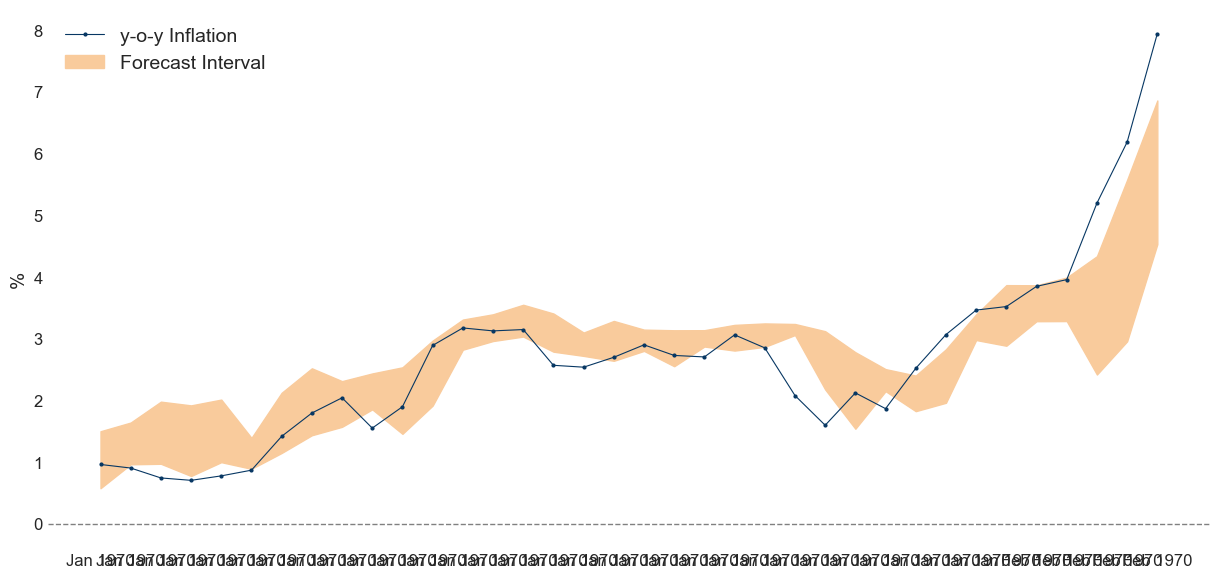

In [69]:
plt.style.use('seaborn-v0_8-dark')
fig, ax = plt.subplots(figsize=(15, 7))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(only_validation.index, only_validation["cpi"], label="y-o-y Inflation ", color='#073763', linewidth=0.8, marker='o', markersize=2)
ax.fill_between(only_validation.index, only_validation["min"], only_validation["max"], alpha=1.0, color='#f9cb9c', label="Forecast Interval")
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_ylabel("%", fontsize=14)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

#fig.savefig('/content/drive/MyDrive/Research/CEMLA 2024/Monthly_Forecast_interval.png', dpi=300, bbox_inches='tight')

In [ ]:
mse_train_w_avg = mean_squared_error(y_train, et_train_pred)
r2_train_w_avg = r2_score(y_train, et_train_pred)
mae_train_w_avg = mean_absolute_error(y_train, et_train_pred)

In [53]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()
# Add line plots for each model's predictions
for col in f2_all_pred.columns[1:-1]:
    fig.add_trace(go.Scatter(x=f2_all_pred.index, y=f2_all_pred[col], mode='lines', name=col))
# Add a bar plot for the 'cpi' values
fig.add_trace(go.Bar(x=f2_all_pred.index, y=f2_all_pred['cpi'], name='cpi', opacity=1.0))

# Update layout for better visualization
fig.update_layout(
    title='Model Predictions and CPI Over Time',
    xaxis_title='Date',
    yaxis_title='Value',
    legend_title='Model',
    template='plotly_white'
)

# Show the plot
fig.show()

#### End